<a href="https://colab.research.google.com/github/Morningspread/Angry-Tweeter/blob/main/Fear_Train_Refactor_RNN_Dec14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Refactoring the code for RNN training 

##Want as few training steps as possible...

##Source of [codebook](https://katoch.medium.com/twitter-emotion-recognition-using-rnn-d3cd59862957)

Data source: Gutenberg 2000 ~ 166K rows...

#To do: 


1.  Adding column modifications...!?
2.   List item



In [ ]:
#Need pip install tensorflow with...Jupyter Notebook

!pip install nlp
#!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd


In [ ]:
#Dec 7, 2022: Not sure what this piece of code is used for... 

import warnings
warnings.filterwarnings('ignore')

##Importing the dataset.. 

In [ ]:
# Load the Drive helper and mount

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load dataset for the 

#/content/drive/MyDrive/Sean/Emoclass_Dec2022/Fear_arousal/Emotion datasets/fear_arousal_first2000books_w400.csv

df=pd.read_csv("/content/drive/MyDrive/Sean/Emoclass_Dec2022/Fear_arousal/Emotion datasets/fear_arousal_first2000books_w400.csv")

In [ ]:
print(df.shape)
df.head(5)

(151724, 4)


,Unnamed: 0,text,emotion1,emotion2
0,0,of a safe next instant the street was empty ba...,panic,dread
1,1,aw now horn and pelt our peoples melt in cover...,dread,dread
2,2,an unwatched flame brightened for a moment an...,dread,dread
3,3,sign turn thee from thy morning mist or twili...,dread,dread
4,4,nted hathi oh but my tusks were red at bhurtpo...,horror,dread


In [ ]:
#What emotion categories do we have? 

print(df['emotion1'].value_counts())

print(df['emotion2'].value_counts())

fear           35438
afraid         19448
anxious        10561
calm            9192
concerning      8439
anxiety         7629
frightened      7498
horror          7451
concerned       7416
dread           6722
fearful         5134
concern         4422
peaceful        4043
worry           3604
fright          3286
worried         2691
serene          2640
panic           2582
horrified       1697
frightening     1035
worrying         784
angst             12
Name: emotion1, dtype: int64
fear       71839
concern    20277
dread      18452
anxiety    18202
calm       15875
worry       7079
Name: emotion2, dtype: int64


In [ ]:
#Relabelling a column... if needed... 

df.rename(columns={"emotion2": "label"},inplace =True)

In [ ]:
#Let's see if we have missing values...No missing values... 

df.isna().sum()

Unnamed: 0    0
text          0
emotion1      0
label         0
dtype: int64

#Replacing the emotion words in the dataset.. 

In [ ]:
#Generate all the unique emotion words that then get replaced... 

a = df['emotion1'].unique().tolist()

#The list a is our list of variable responses from the dataset... 

words = a
for j in words: 
  df['text'] = df['text'].str.replace(j,'emotions')

In [ ]:
#Shuffling the dataset

df = df.sample(frac=1)

#Experimenting with truncating string length from both sides... 

##This section needs work

##Splitting string without word gap  [link here](https://stackoverflow.com/questions/250357/truncate-a-string-without-ending-in-the-middle-of-a-word)



In [ ]:
#Let's create a string length variable...

df['text_len'] = df['text'].str.len()

#Now, let's look at the value counts of this... 

df['text_len'].describe()

count    151724.000000
mean        404.581147
std           7.642324
min         206.000000
25%         402.000000
50%         403.000000
75%         404.000000
max         498.000000
Name: text_len, dtype: float64

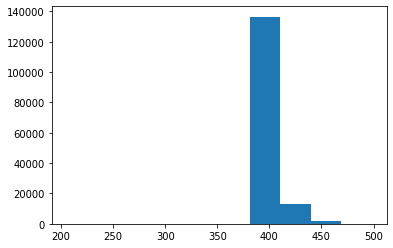

In [ ]:
#WHere would the... 

plt.hist(df['text_len'])
plt.show()

In [ ]:
#Shortening the string length...This isn't a bad solution...want to move to 
#The center of the string is at about 200 -> so like 75 on either sie... 


df['short_text'] = df['text'].str.slice(0,400)

df['shorttext_len'] = df['short_text'].str.len()

#Checking our transformation...

df['shorttext_len'].describe()

count    151724.000000
mean        399.836558
std           2.700652
min         206.000000
25%         400.000000
50%         400.000000
75%         400.000000
max         400.000000
Name: shorttext_len, dtype: float64

In [ ]:
#Let's see what this looks like...

df.head()

#Consider export here... 

,Unnamed: 0,text,emotion1,label,text_len,short_text,shorttext_len
27559,27559,hen through ignorance or emotions there is no ...,fear,fear,408,hen through ignorance or emotions there is no ...,400
146627,146627,true indian grunt fill his excellency the int...,fear,fear,404,true indian grunt fill his excellency the int...,400
27263,27263,e our trusty blades hew their way through wood...,afraid,fear,402,e our trusty blades hew their way through wood...,400
125892,125892,erself the watchers in the gallery followed th...,fright,fear,404,erself the watchers in the gallery followed th...,400
76912,76912,"their heads this had the , emotions , emotions...",frightening,fear,413,"their heads this had the , emotions , emotions...",400


In [ ]:
#Create a new dataframe... 

df=pd.DataFrame(df,columns=['short_text','label'])

#Let's check this... 

df.head()

,short_text,label
27559,hen through ignorance or emotions there is no ...,fear
146627,true indian grunt fill his excellency the int...,fear
27263,e our trusty blades hew their way through wood...,fear
125892,erself the watchers in the gallery followed th...,fear
76912,"their heads this had the , emotions , emotions...",fear


# Splitting dataset into train, validate and test datasets
---

Dec 12: May want to split dataset in half again...to see impact of sample size on training...hypothesis: more data will increase accuracy...with RNN....

In [ ]:
#This seems to be hte simplest way to do the 3 way training split...
#And then this outputs 3 different dataframes... 

train, validate, test = np.split(df, 
                       [int(.6*len(df)), int(.8*len(df))])

In [ ]:
#Checking to make sure that all three are dataframes... 

type(train),type(validate),type(test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [ ]:
#Looking at the dataframe...

train.head()
print(train.shape)

(91034, 2)


# 6. Preparing the Labels

## In terms of sequence, I think this should go right below the dataframe -> List code

In [ ]:
#Converting the pandas dataframe into a list of labels... 
#We may consider puting this into a function... 

trainlabel=train['label'].tolist()
vallabel=validate['label'].tolist()
testlabel=test['label'].tolist()

{'calm', 'worry', 'dread', 'fear', 'anxiety', 'concern'}


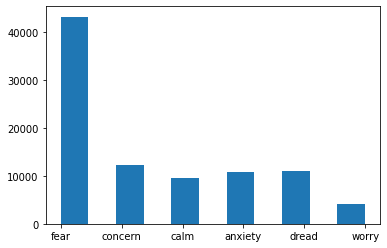

In [ ]:
#Convert the labels into a a set(just unique values) and print them...
#Labels is a list... 

classes = set(trainlabel)
print(classes)

#What is the distribution of emotions in our literature? Histogram...  
#Bins 11 -> number of classifiers, with the number of spaces imbetween...

plt.hist(trainlabel, bins=11)
plt.show()

In [ ]:
#One thing that ***I don't*** like about this way of doing things is that the ordering of the variables is a bit...!?!

classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [ ]:
#This is simply a dictionary -> and it becomes an input into an 

classes_to_index

#Dec 12, I'm not sure what this is supposed to be for.. 

index_to_classes

{0: 'calm', 1: 'worry', 2: 'dread', 3: 'fear', 4: 'anxiety', 5: 'concern'}

In [ ]:
#Creating a lambda function...called "names_to_ids"

names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [ ]:
#Applying the names_to_ids functions to the labels

train_labels = names_to_ids(trainlabel)
val_labels = names_to_ids(vallabel)
test_labels = names_to_ids(testlabel)

#Testing out the labels...
print(train_labels[10])

4


In [ ]:
#Dec 13, 2022 - I am getting an error because my x and y are not matching...
#train_labels is an ndarray -> 99789... 
#val_labels is: 33253

#val_labels


# 4. Tokenizing the Tweets

## I don't know what "fit on texts" is supposed to do... 

See reference [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)


In [ ]:
#Converting the different pandas dataframes into a list of text fields...
#This is like prime for being 

traintext=train['short_text'].tolist()
valtext=validate['short_text'].tolist()
testtext=test['short_text'].tolist()

In [ ]:
#What's the length of each of these things... 

print(len(traintext)),print(len(valtext)),print(len(testtext))

91034
30345
30345


(None, None, None)

In [ ]:
#Importing the tokenizer...
#Input into the tokenizer is a list

from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
#Input into the tokenizer is a list

tokenizer = Tokenizer(num_words=50000, oov_token='<UNK>')

#I think that this is the missing piece...I'm not really sure what it does...  

tokenizer.fit_on_texts(traintext)
#tokenizer.fit_on_texts(valtext)

#Testing the tokenization... 

#print(tokenizer.texts_to_sequences([tweets[10]]))

## 5. Padding and Truncating Sequences

See this resource on padding sequence by Keras
https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#Creating a function that tokenizes and pads the sequences...

def get_sequences(tokenizer, texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=400, padding='post')
    return padded_sequences

In [ ]:
#Applying the function to tokenize and pad... to all test,validate and test
#Syntax: val_sequences = get_sequences(tokenizer, val_tweets)

padded_train_sequences = get_sequences(tokenizer, traintext)
val_sequence = get_sequences(tokenizer,valtext)
test_sequence = get_sequences(tokenizer,testtext)


In [ ]:
#Let's see what kind of shape these things are...
#padded_train_sequences is an Ndarray is 99789

#Alright...val_sequence is 99789....

#val_sequence



# 7. Creating the Model

##Dec 7: Need to better understand the hyperparameters here... 


1.   What is the 2nd argument in it? Words, X and input length...
2.   List item


In [ ]:
#I think that the embedding layer works on the number of words... 
#

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(50000, 1000, input_length=400),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 1000)         50000000  
                                                                 
 bidirectional (Bidirectiona  (None, 400, 400)         1921600   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 400)              961600    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 2406      
                                                                 
Total params: 52,885,606
Trainable params: 52,885,606
Non-trainable params: 0
_________________________________________________________________






































## 8. Training the Model

In [ ]:
#Having the callbacks option on means that the model stops once you are like over-generalizing... 
#Let's leave the callback option on for now...


h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequence, val_labels),
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
   ]
)

Epoch 1/10
2845/2845 [==============================] - 305s 104ms/step - loss: 1.0400 - accuracy: 0.6239 - val_loss: 0.7668 - val_accuracy: 0.7190
Epoch 2/10
2845/2845 [==============================] - 296s 104ms/step - loss: 0.5774 - accuracy: 0.7961 - val_loss: 0.6287 - val_accuracy: 0.7748
Epoch 3/10
2845/2845 [==============================] - 296s 104ms/step - loss: 0.3211 - accuracy: 0.8899 - val_loss: 0.7053 - val_accuracy: 0.7683
Epoch 4/10
2845/2845 [==============================] - 295s 104ms/step - loss: 0.1649 - accuracy: 0.9452 - val_loss: 0.8583 - val_accuracy: 0.7547


#9. Evaluating the model 

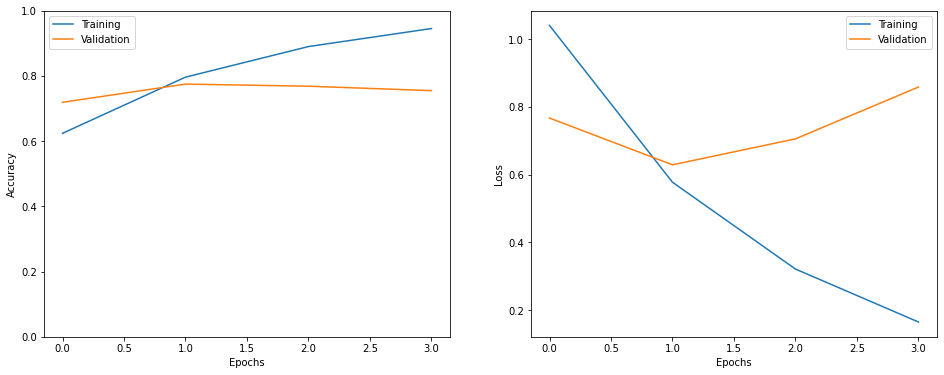

In [ ]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

In [ ]:
#Running the model on the test sequence and test labels... 

eval = model.evaluate(test_sequence, test_labels)

949/949 [==============================] - 37s 39ms/step - loss: 0.8706 - accuracy: 0.7540


In [ ]:
#preds = model.predict_classes(test_sequences)
preds=model.predict(test_sequences) 
classes_x=np.argmax(preds,axis=1)
preds.shape, test_labels.shape

NameError: ignored

#Saving the model 

##Questions: At what point do we save the model...


1.   Resolve the character / length piece in looking at the inference dataset...
2.   I want the 75% run / run before I save it... 



In [ ]:
#So this works but we need to make sure that we install Keras as a dependency 

from keras.models import load_model

#model.save("my_model")

#fearmodel.save('/content/drive/MyDrive/Sean/Emoclass_Dec2022/Fear_arousal/Fear_Arousal_Model_6cat_dec10,2022')